### Goal:

Write a Qiskit function that takes one input: a positive integer $d$ and outputs a quantum circuit, QCalc, on $3d +1$ qubits, possibly with further ancillas, that implements the following:

$\text{QCalc}(\Ket{x}_d \Ket{y}_d \Ket{z}_1 \Ket{0}_d) = \begin{cases} \Ket{x}_d \Ket{y}_d \Ket{z}_1 \Ket{x + y \mod 2^d}_d \text{  ,if  } z = 0, \\ \Ket{x}_d \Ket{y}_d \Ket{z}_1 \Ket{x \cdot y \mod 2^d}_d \text{  ,if  } z = 1  \end{cases}$

### Part 1: 

To start, we implement a controlled Adder circuit QAdd, which takes as input $\Ket{x}_d \Ket{y}_d  $ and outputs $\Ket{x}_d  \Ket{x+y \mod 2^d }$. We do this using similar techniques to the Draper Adder with the QFT as a subroutine. 

In [127]:
#Import libraries:
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
import numpy as np

ModuleNotFoundError: No module named 'qiskit.providers.aer'

###  Controlled QFT and QFT subcircuits:

To start with, we need to implement the Quantum Fourier Transform and the inverse Quantum Fourier Transform. We recall the definition of the quantum Fourier transform. For any integer $x \in \{0,1,\dots, 2^d-1\}$, we define the transformation $$ QFT \Ket{x} = \frac{1}{\sqrt{2^d}} \sum_{z=0}^{2^{d}-1} e^{\frac{2 i \pi}{2^d} xz} \Ket{z}  \; ,$$

and the inverse QFT to be 
$$ IQFT \Ket{x} = \frac{1}{\sqrt{2^d}} \sum_{z=0}^{2^{d}-1} e^{-\frac{2 i \pi}{2^d} xz} \Ket{z}  \; ,$$

We use a standard implementation of QFT, as defined in notebook 2. 

In [31]:
def QFT(d):
    x=QuantumRegister(size=d, name="x")
    control=QuantumRegister(size=1, name="z")
    circuit=QuantumCircuit(x,control,name="QFT")
    for i in range(d):
        circuit.h(x[i])
        for j in range(d-2-i):
            circuit.CR(j+2, x[i], x[i+j+1])
    return circuit
def IQFT(d):
    x=QuantumRegister(size=d, name="x")
    control=QuantumRegister(size=1, name="z")
    circuit=QuantumCircuit(x,control,name="QFT")
    for i in range(d):
        circuit.h(x[i])
        for j in range(d-2-i):
            circuit.CR(j+2, x[i], x[i+j+1])
    return circuit
    

In [101]:
#The following is just the implementation from notebook 2.

def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit

In [46]:
QFT=quantum_fourier_transform(4)
IQFT=QFT=inverse_quantum_fourier_transform(4)
circuit = QFT.compose(IQFT)
np.round(Operator(circuit).data, 4)

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j, -0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j,
        -0.+0.j,  0.+0.j, -0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.-0.j,
         0.+0.j,  1.+0.j],
       [ 0.+0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         1.+0.j,  0.+0.j],
       [ 0.+0.j, -0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j,
         0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j,  1.+0.j,
         0.+0.j, -0.-0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j, -0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j,
         0.-0.j,  0.+0.j,  0.-0.j,  0.+0.j,  1.+0.j,  0.+0.j, -0.-0.j,
         0.+0

### Designing the Quantum Adder circuit: 

Suppose there exists a circuit $A$, such that $A \Ket{x} \Ket{y}=\Ket{x}{x+y \mod 2^d}$ (from here on, we will drop the $\mod 2^d$, and assume all addition is performed modulo $2$. We prove the following statement: 

**Lemma:** $A=(I \otimes IQFT) \circ e^{\frac{2 \pi i}{2^d} xy} \circ(I \otimes QFT) $. 

**Proof**: The proof is similar to Draper's Lemma. We use the fact that $A \circ (I \otimes IQFT) \Ket{x}\Ket{y}=\sum_{y'=0}^{2^d-1} e^{-\frac{2 \pi i}{2^d}y y'} \Ket{x} \Ket{y+x}$. Factoring out $e^{\frac{2 \pi i}{2^d} x y}$, we get that this is equal to $e^{\frac{2 \pi i}{2^d} x y} (I \otimes IQFT) \Ket{x} \Ket{y}$. Hence, we get that $A \circ(I \otimes IQFT) \Ket{x}\Ket{y}= e^{\frac{2 \pi i}{2^d} x y} (I \otimes IQFT) \Ket{x} \Ket{y}$. Postmultiplying on both sides by $(I \otimes QFT)$ proves this lemma.

Now, it is enough to implement the gate that takes $\Ket{x}\Ket{y}$ to $e^{\frac{2 \pi i}{2^d} x y} \Ket{x}\Ket{y}$. We now show that this can just be implemented using controlled phase shift gates (CP gates). 

$$e^{\frac{2 \pi i}{2^d} x y} \Ket{x}\Ket{y}=e^{\frac{2 \pi i}{2^d} \left(\sum_{j=0}^{d-1}x_j 2^j\right)\left(\sum_{k=0}^{d-1} y_k 2^k\right)} \Ket{x}\Ket{y} = \bigotimes_{j=0}^{d-1}\bigotimes_{k=0}^{d-1} e^{\frac{2 \pi i}{2^{d-j-k}}x_j y_k} \Ket{x_j}\Ket{y_k} \; .$$

Now, we design the Quantum Adder using qiskit's CP gate implementation. In the final version of the quantum calculator, we plan to implement this from scratch. 

### Phase shift subcircuit: 

**Input:** Any state vector $\Ket{x}_d \Ket{y}_d$ 

**Output:** $e^{2 \pi i xy/2^d} \Ket{x}_d \Ket{y}_d$(viewing $x$ and $y$ as $d$ bit integers). 

We start by noting that  $e^{2 \pi i xy/2^d} \Ket{x}_d \Ket{y}_d=\bigotimes_{j=0}^{d-1} \bigotimes_{k=0}^{d-1} e^{\frac{2 \pi i}{2^{d-j-k}}x_j y_k} \Ket{x_k} \Ket{y_k}$. Hence, it is enough to implement the unitary operation $\Ket{x}_1 \Ket{y}_1 \to U(0,0,\frac{2 \pi i}{2^{d-j-k}} x y) \Ket{x}_1\Ket{y}_1$

In [120]:
from numpy import pi
def PhaseShift(d):
    #Adds a phase shift of e^(2 \pi i xy/2^d)
    register_x=QuantumRegister(size=d, name="x")
    register_y=QuantumRegister(size=d, name="y")
    circuit=QuantumCircuit(register_x,register_y, name="Phase-Shift")
    for j in range(d):
        for k in range(d):
            theta=2 *np.pi/2**(d-j-k)
            circuit.cp(theta, register_x[j], register_y[k], label=None, ctrl_state=None)
    return circuit
    

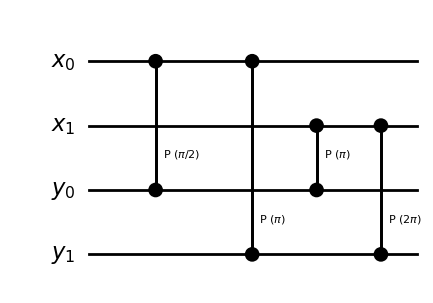

In [86]:
circ=PhaseShift(2)
circ.draw(output="mpl", style="bw")

In [129]:
def QuantumAdder(d):
    register_x = QuantumRegister(size=d, name="x")
    register_y = QuantumRegister(size=d, name="y")
    #register_control = QuantumRegister(size=1, name="control")
    #register_out = QuantumRegister(size=d, name="output")
    circuit=QuantumCircuit(register_x,register_y, name="QAdd")

    PhaseShiftCircuit=PhaseShift(d)
    QFTCircuit=quantum_fourier_transform(d)
    QFTinvCircuit=inverse_quantum_fourier_transform(d)
    
    circuit.compose(QFTCircuit, qubits=register_y, inplace=True)   
    circuit.barrier()
    circuit.compose(PhaseShiftCircuit, qubits=register_x[:]+ register_y[:], inplace=True)
    circuit.barrier()
    circuit.compose(QFTinvCircuit, qubits=register_y[:], inplace=True)
    
    return circuit

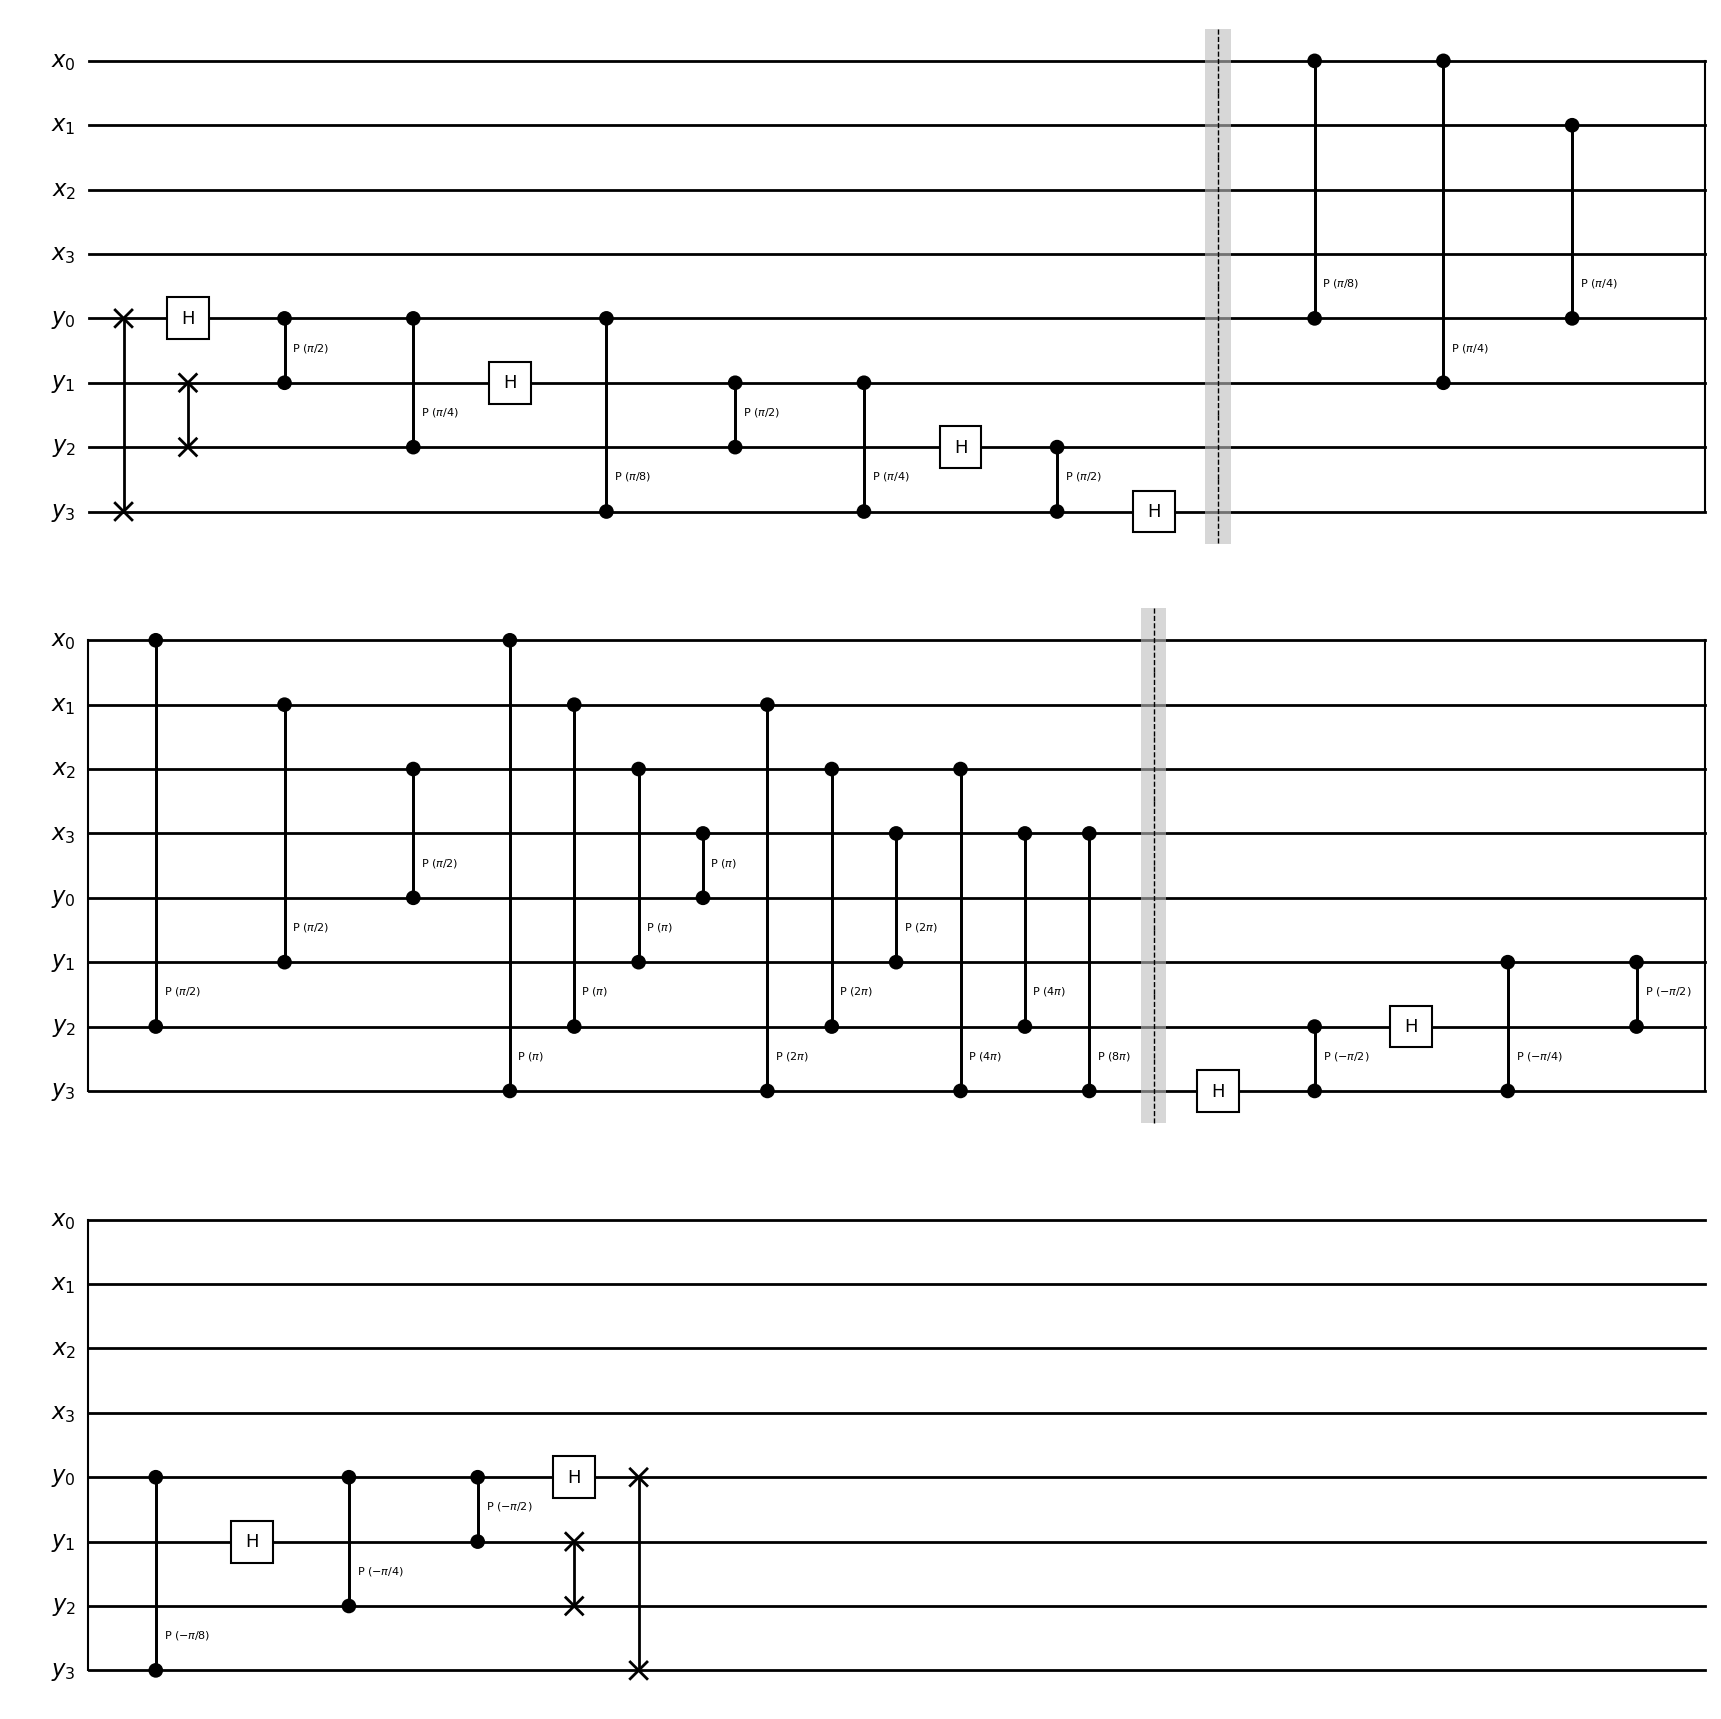

In [130]:
##Diagram of the quantum Adder circuit for $d=4$:
QAdd=QuantumAdder(4)
QAdd.draw(output="mpl", style="bw")

### Benchmarking the Quantum Adder: 

As a first step, we check that the quantum adder defined above works, and benchmark it. We use $d=3$, and use the numbers $2=010$ and $4=100$. The sum should be $6=110$. 

In [179]:
##Benchmarking:
num1=[0,1,0]
num2=[0,0,1]

## Define the circuit.
QAdd=QuantumAdder(3)

##Define starting state:
# Define the basis state as a string (most significant qubit on the left)
bitstring = '010001'

# Convert to Statevector
state = Statevector.from_label(bitstring)
state.draw("Latex")
##Evolve the state

final_state = state.evolve(QAdd)


In [180]:
final_state.draw("Latex")

<IPython.core.display.Latex object>

### A Quantum Multiplier: 

Our quantum multiplier simply performs repeated additions. Here, we design a circuit QMult that takes as input a state $\Ket{x}_d \Ket{y}_d \Ket{0}_d$ and outputs $QMult \Ket{x}_d \Ket{y}_d \Ket{0}_d=\Ket{x}_d \Ket{y}_d \Ket{x \cdot y\mod 2^d}_d$. Our circuit for multiplication essentially performs addition $d$ times, using the "high school" algorithm for multiplication. To be precise, we define $d$ Blocks of the earlier defined QAdd circuit, with the first block adding $y$ to the zeros if the least significant bit of $x$ is $1$, followed by a block adding $2y$ to earlier output if the second least significant but of $x$ is $1$, and so on. Similar ideas have been employed in https://arxiv.org/pdf/1411.5949, although their circuits are significantly simplified and more efficient. To do this however, we will need controlled versions of the quantum adder. 

In [ ]:
def QuantumMultiplier(d):
    register_x = QuantumRegister(size=d, name="x")
    register_y = QuantumRegister(size=d, name="y")
    register_out = QuantumRegister(size=d, name="output")

In [ ]:
def QuantumCalculator(d):